# Escuela de ML y DL Módulo 2
# Tarea 1. Ejercicio con una CNN
# Arnoldo Fernando Chue Sánchez
# arnoldwork20@gmail.com
# Agosto de 2024

## Contenido
1. Planteamiento del problema
2. Planteamiento de la solución
3. Ejemplo de ejecución
4. Conclusiones
5. Referencias

## Planteamiento del problema
Para esta actividad tenemos las siguientes indicaciones:
* Utilizando el dataset de Fashion MNIST de Keras, construir un mejor modelo de predicción utilizando una CNN.
* Debe mostrarse el entrenamiento por épocas, la pérdida y el nivel de precisión del modelo (mejorado)
* Para determinar la generalización del modelo propuesto, utilizar imágenes del conjunto de prueba
* Entregar el reporte de acuerdo a la rúbri

Específicamente vamos a tratar de alcanzar un accuracy del 90%.

## Planteamiento de la solución
Vamos a comenzar importando las librerías con las que vamos a trabajar.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2024-08-12 06:53:31.969836: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Vamos a verificar que estemos trabajando con la GPU

In [2]:
tf.config.list_physical_devices('GPU')

2024-08-12 06:53:34.102990: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-08-12 06:53:34.104462: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-08-12 06:53:34.147679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 06:53:34.147939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:08.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.455GHz coreCount: 6 deviceMemorySize: 3.94GiB deviceMemoryBandwidth: 104.43GiB/s
2024-08-12 06:53:34.147982: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-08-12 06:53:34.151051: I tensorflow/stream_executor/platform/

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

latform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2024-08-12 06:53:34.153345: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2024-08-12 06:53:34.153835: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2024-08-12 06:53:34.156845: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusolver.so.10
2024-08-12 06:53:34.158364: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusparse.so.10
2024-08-12 06:53:34.164573: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-08-12 06:53:34.164854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node,

Todo parece en orden, sólo que vamos a evitar que nos salgan estas advertencias 

In [3]:
import warnings
warnings.filterwarnings('ignore')

Ahora pasemos con el primer paso: preprocesar los datos. Dado que vamos a usar el dataset MNIST de moda comenzemos con la descarga

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist

Dividamos el conjunto de entrenamiento del de prueba

In [5]:
(trainX, trainY), (test_images, test_labels) = fashion_mnist.load_data()

In [6]:
trainX.shape

(60000, 28, 28)

In [7]:
trainY.shape

(60000,)

Vamos a crear también el conjunto de validación para el momento del entrenamiento de nuestra red neuronal durante sus épocas

In [8]:
train_images, validation_images = trainX[:55000,:,:], trainX[55000:,:,:]
train_labels, validation_labes = trainY[:55000], trainY[55000:]

In [9]:
train_images.shape

(55000, 28, 28)

In [10]:
validation_images.shape

(5000, 28, 28)

In [11]:
train_labels.shape

(55000,)

In [12]:
validation_labes.shape

(5000,)

Ahora podemos guardar el nombre de las clases

In [13]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [14]:
train_labels

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Aquí podemos observar que las etiquetas están con un número diferente. No están como una matriz en formato OHE. Por lo que tendremos que tomarlo en cuenta al momento de definir nuestro modelo

Ahora bien, en cuanto a preprocesamiento de los datos, vamos a dejar las imágenes en blanco y negro dejando sus pixeles en un rango del 0 al 1. Esto se consigue dividiéndolas entre 255

In [15]:
train_images, validation_images, test_images = train_images/255, validation_images/255, test_images/255

Veamos si lo tenemos en el formato correcto

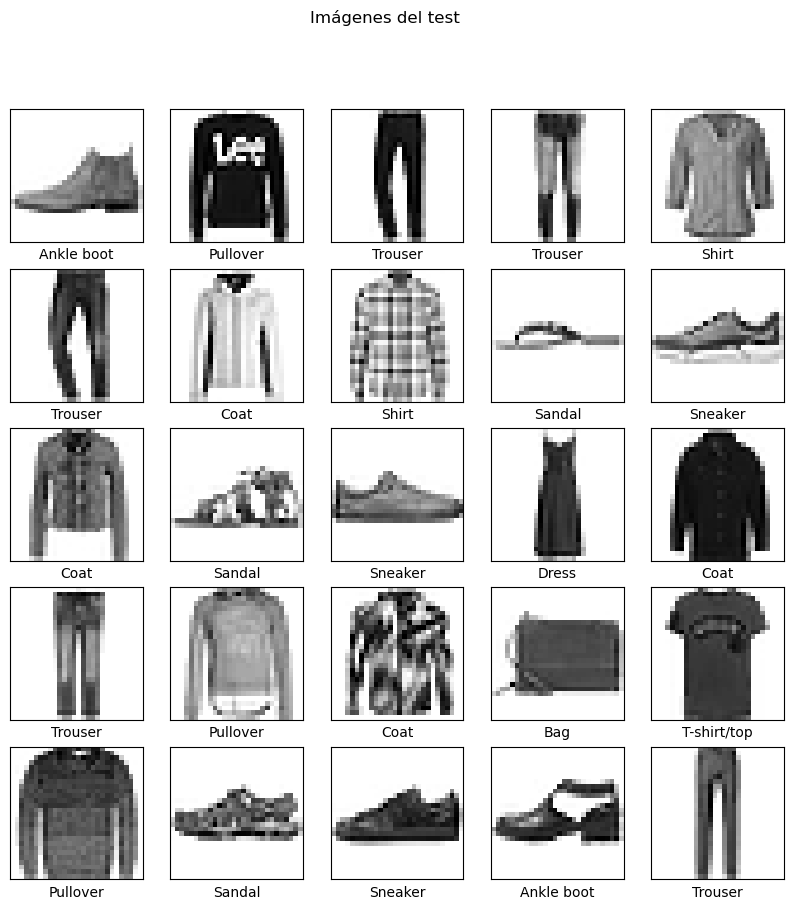

In [16]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[test_labels[i]])
plt.suptitle("Imágenes del test")
plt.show()

Con esto podemos pasar a la actividad principal de esta actividad: contruir un modelo de una red neuronal convolucional

Vamos a comenzar con la siguiente propuesta sencilla de arquitectura:
* Una capa convolucional de entrada con 128 mapas de 3x3, función de activación y adaptación para leer las imágenes de 28x28 en escala de grises
* Una capa convolucional de 64 mapas de 3x3 y función de activación relu
* Una capa de max pooling con kernel y stride de 2x2
* Una capa convolucional de 32 mapas de 3x3 y función de activación relu
* Una capa de max pooling con kernel y stride de 2x2
* Una capa convolucional de 16 mapas de 3x3 y función de activación relu
* Una capa de max pooling con kernel y stride de 2x2
* Una capa de flatten para pasar a las capas densas
* Una capa densa de 300 neuronas con función de activación relu
* Una capa densa de 120 neuronas con función de activación relu
* Finalmente, una capa de 10 neuronas con la función de activación softmax para la clasificación

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(20062002)

model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=[28,28,1]),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

2024-08-12 06:54:06.625242: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 06:54:06.625959: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-08-12 06:54:06.626238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 06:54:06.626479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:08.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.455GHz coreCount: 6 deviceMemorySize: 3.94GiB deviceMemoryBandwidth: 104.43GiB/s
2024-0

In [19]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        73792     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 16)          0

Vamos a realizar la compilación del modelo. En este caso nuestra función de pérdida será la entropía cruzada categórica y específicamente la sparse porque nuestras etiquetas no están en formato OHE. Sobre el optimizador usaremos adam para nuestra métrica de efectividad (accuracy).

In [20]:
model1.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

Comenzemos el entrenamiento con 30 épocas e iremos analizando con nuestro conjunto de validación. Sin embargo, por un error que ya nos generó el modelo al entrenar, necesitamos ajustar la dimensión de las imágenes

In [17]:
train_images = np.expand_dims(train_images, axis=-1)
validation_images = np.expand_dims(validation_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

In [21]:
history1 = model1.fit(train_images, train_labels, 
                     epochs=30, 
                     validation_data=(validation_images, validation_labes))

2024-08-12 06:54:23.449875: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-08-12 06:54:23.450514: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2261055000 Hz


Epoch 1/30


2024-08-12 06:54:24.189628: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-08-12 06:54:24.443873: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


1719/1719 [==============================] - 18s 9ms/step - loss: 0.8129 - accuracy: 0.6895 - val_loss: 0.4404 - val_accuracy: 0.8372
Epoch 2/30
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4167 - accuracy: 0.8447 - val_loss: 0.3981 - val_accuracy: 0.8530
Epoch 3/30
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3493 - accuracy: 0.8713 - val_loss: 0.3266 - val_accuracy: 0.8792
Epoch 4/30
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3185 - accuracy: 0.8821 - val_loss: 0.3482 - val_accuracy: 0.8730
Epoch 5/30
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2894 - accuracy: 0.8935 - val_loss: 0.3013 - val_accuracy: 0.8846
Epoch 6/30
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2698 - accuracy: 0.8994 - val_loss: 0.3043 - val_accuracy: 0.8924
Epoch 7/30
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2566 - accuracy: 0.9050 - val_loss: 0.3148 - val_accuracy: 0.8

Aquí tenemos dos resultados interesantes. El primero es que con esta arquitectura logramos alcanzar el 90% de accuracy que nos habíamos propuesto al inicio de la práctica. Sin embargo, también notamos que a partir de la época 18 podemos ver que el modelo está sobreajustando: sube al accuracy en los datos de entrenamiento pero no lo sube en los de validación. Esto lo podemos justificar con lo mencionado en clase sobre el optimizador adam: en la práctica este modelo converge aproximadamente en la época 20. Por lo que podemos repetir el entrenamiento, pero con el número de épocas adecuadas: 17

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(20062002)

model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=[28,28,1]),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [27]:
model2.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [28]:
history2 = model2.fit(train_images, train_labels, 
                     epochs=17, 
                     validation_data=(validation_images, validation_labes))

Epoch 1/17
1719/1719 [==============================] - 16s 9ms/step - loss: 0.8100 - accuracy: 0.6923 - val_loss: 0.4571 - val_accuracy: 0.8294
Epoch 2/17
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4091 - accuracy: 0.8484 - val_loss: 0.3711 - val_accuracy: 0.8640
Epoch 3/17
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3463 - accuracy: 0.8727 - val_loss: 0.3212 - val_accuracy: 0.8784
Epoch 4/17
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3165 - accuracy: 0.8849 - val_loss: 0.3183 - val_accuracy: 0.8790
Epoch 5/17
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2834 - accuracy: 0.8954 - val_loss: 0.3001 - val_accuracy: 0.8872
Epoch 6/17
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2640 - accuracy: 0.9029 - val_loss: 0.3022 - val_accuracy: 0.8900
Epoch 7/17
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2503 - accuracy: 0.9086 - val_loss: 0.3034 - val_ac

Ya que tenemos un modelo sobreajustado y uno que se supone que no lo está, podemos proponer otra arquitectura para ver si logramos superar el 90% de accuracy:
* Vamos a invertir el número de mapas por capa convolucional: de 16 a 128 en orden de menor a mayor
* El tamaño de los mapas tanto en las capas de convolución, como en las de max pooling será de 2x2
* Agregaremos una capa más en la sección de capas densas: una de 545 neuronas previa a la de 300

In [29]:
tf.keras.backend.clear_session()
tf.random.set_seed(20062002)

model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (2,2), activation='relu', input_shape=[28,28,1]),
    tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(545, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [30]:
model3.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

En este caso vamos a usar las 20 épocas exactas en las que aproximadamente converge el optimizador adam

In [31]:
history3 = model3.fit(train_images, train_labels, 
                     epochs=20, 
                     validation_data=(validation_images, validation_labes))

Epoch 1/20
1719/1719 [==============================] - 10s 5ms/step - loss: 0.7443 - accuracy: 0.7242 - val_loss: 0.3874 - val_accuracy: 0.8546
Epoch 2/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3568 - accuracy: 0.8660 - val_loss: 0.2998 - val_accuracy: 0.8862
Epoch 3/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2953 - accuracy: 0.8900 - val_loss: 0.2788 - val_accuracy: 0.8920
Epoch 4/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2645 - accuracy: 0.9024 - val_loss: 0.2733 - val_accuracy: 0.8954
Epoch 5/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2334 - accuracy: 0.9141 - val_loss: 0.2564 - val_accuracy: 0.9088
Epoch 6/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2136 - accuracy: 0.9203 - val_loss: 0.2794 - val_accuracy: 0.9024
Epoch 7/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1985 - accuracy: 0.9265 - val_loss: 0.2922 - val_accuracy

Parece que este nuevo modelo también converge en el 90% de accuracy en el conjunto de validación. Por lo que haremos un último intento con otra arquitectura:
* Usaremos el mismo número de filtros por capa convolucional: 128


In [33]:
tf.keras.backend.clear_session()
tf.random.set_seed(20062002)

model4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (2,2), activation='relu', input_shape=[28,28,1]),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(545, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [34]:
model4.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [35]:
history4 = model4.fit(train_images, train_labels, 
                     epochs=20, 
                     validation_data=(validation_images, validation_labes))

Epoch 1/20
1719/1719 [==============================] - 22s 12ms/step - loss: 0.7118 - accuracy: 0.7355 - val_loss: 0.3547 - val_accuracy: 0.8660
Epoch 2/20
1719/1719 [==============================] - 20s 12ms/step - loss: 0.3305 - accuracy: 0.8784 - val_loss: 0.2817 - val_accuracy: 0.8974
Epoch 3/20
1719/1719 [==============================] - 20s 12ms/step - loss: 0.2716 - accuracy: 0.8999 - val_loss: 0.2508 - val_accuracy: 0.9000
Epoch 4/20
1719/1719 [==============================] - 20s 12ms/step - loss: 0.2461 - accuracy: 0.9105 - val_loss: 0.2716 - val_accuracy: 0.8988
Epoch 5/20
1719/1719 [==============================] - 20s 12ms/step - loss: 0.2145 - accuracy: 0.9210 - val_loss: 0.2699 - val_accuracy: 0.9056
Epoch 6/20
1719/1719 [==============================] - 20s 12ms/step - loss: 0.1954 - accuracy: 0.9268 - val_loss: 0.2702 - val_accuracy: 0.9104
Epoch 7/20
1719/1719 [==============================] - 20s 12ms/step - loss: 0.1775 - accuracy: 0.9333 - val_loss: 0.2806 -

Este modelo parece ser que es el mejor hasta ahora porque en la mayoría de las épocas se mantuvo en el 91% de accuracy en el conjunto de validación. De hecho, en la época 11 alcanzó el 92% de efectividad. Sin embargo, parece que esta convergencia se alcanza aproximadamente en la época 15, ya que posteriormente tiende a sobreajustar.

## Ejemplos de ejecución

Veamos entonces cuál de nuestros modelos es el ganador al momento de predecir con los conjuntos de prueba

**Modelo 1. Arquitectura convolucional de mayor a menor sobreajustado con 2 capas en la parte densa**

In [37]:
model1.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.3813 - accuracy: 0.8965


[0.3812725841999054, 0.8964999914169312]

Vemos que no alcanza el 90% de accuracy y la entropía cruzada categórica queda relativamente alta: 38%

**Modelo 2. Arquitectura convolucional de mayor a menor no sobreajustado con 2 capas densas**

In [38]:
model2.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.3505 - accuracy: 0.8981


[0.3505280017852783, 0.8981000185012817]

Sorprendentemente da el mismo resultado que su contraparte con la misma arquitectura, pero menor número de épocas

**Modelo 3. Arquitectura convolucional de menor a mayor con 3 capas densas**

In [39]:
model3.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.4391 - accuracy: 0.9046


[0.43909358978271484, 0.9046000242233276]

Este modelo sí consigue llegar al 90% de accuracy (90.46%)

**Modelo 4. Arquitectura convolucional con todas sus capas con el mismo número de filtros y con 3 capas en la parte densa**

In [40]:
model4.evaluate(test_images, test_labels)

313/313 [==============================] - 2s 5ms/step - loss: 0.4055 - accuracy: 0.8987


[0.40552425384521484, 0.8986999988555908]

Este modelo que parecía más prometedor tampoco llegó al 90% de accuracy.

Antes de pasar al análisis y conclusiones es importante guardar los modelos.

In [41]:
import shutil
shutil.rmtree("modelo1_tarea1", ignore_errors=True)
shutil.rmtree("modelo2_tarea1", ignore_errors=True)
shutil.rmtree("modelo3_tarea1", ignore_errors=True)
shutil.rmtree("modelo4_tarea1", ignore_errors=True)

In [42]:
model1.save("modelo1_tarea1", save_format="tf")
model2.save("modelo2_tarea1", save_format="tf")
model3.save("modelo3_tarea1", save_format="tf")
model4.save("modelo4_tarea1", save_format="tf")

2024-08-12 07:42:16.132006: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: modelo1_tarea1/assets
INFO:tensorflow:Assets written to: modelo2_tarea1/assets
INFO:tensorflow:Assets written to: modelo3_tarea1/assets
INFO:tensorflow:Assets written to: modelo4_tarea1/assets


De una vez guardemos los pesos de cada modelo

In [43]:
model1.save_weights("weights1")
model2.save_weights("weights2")
model3.save_weights("weights3")
model4.save_weights("weights4")

## Conclusiones

Si pensamos únicamente en los objetivos iniciales de la práctica: alcanzar el 90% de accuracy con un modelo y practicar lo visto sobre redes neuronales convolucionales, entonces esta tarea cumplió con lo necesario. Sin embargo, personalmente no quedo tan contento con el desempeño de los modelos. Entiendo que llegar más allá del 90% de efectividad es sumamente complicado aun con redes neuronales, pero igualmente uno desea alcanzar cada vez mejores resultados con sus modelos.

En cuanto a aprendizaje útil que logramos obtener de las observaciones de esta práctica tenemos lo siguiente:
* Las redes neuronales son igual o un poco más suceptibles de sobreajustarse que los algoritmos tradicionales de machine learning. Por lo que hay que poner particular atención al número de épocas que le demos para entrenar a los modelos.
* En las redes neuronales convolucionales, parece que es importante y efectivo poner un número grande de filtros en las últimas capas (las previas a pasar a la parte densa de la red). Esto lo podemos explicar porque en esas capas es donde se abstraen los features más complejos de los objetos, por lo que con más filtros podemos conseguir más información en una etapa importante de la visión computacional.

Para futuros trabajos valdría la pena usar otros optimizadores sobre estas mismas arquitecturas. Al menos para averiguar si el sobreajuste afectó fuertemente nuestros modelos. Además, también sería útil comparar otras métricas como el tamaño del stripe, otras reducciones en el pooling o el mismo tamaño de los filtros.

Con esto podemos ver por qué es de los tipos de redes neuronales con los que más se está experimentando actualmente: dan buenos resultados y hay mucho trabajo para experimentar hasta conseguir los mejores resultados

## Referencias

En esta ocasión no fue necesario consultar fuentes externas al material visto en las sesiones del diplomado.